# Athena Rationales Notebook (from Scratch)

>
> Interpreting NLMs of Athena by @davidN
>

In [922]:
from pathlib import Path
import csv
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import functools

pd.options.display.float_format = '{:.2f}'.format

In [923]:
from tokenizers import ByteLevelBPETokenizer

In [924]:
import torch
import importlib
from fairseq.models.transformer import TransformerModel

In [925]:
import warnings
from matplotlib import colors
import os
from rationalization import rationalize_lm, rationalize_conditional_model

In [926]:
def param_default():
    corpus = 'fm_fc_ms_ff' #<-- Scope
    data_path = Path('../athena-datasets/' + corpus + '/')
    data_path_raw = Path('../athena-datasets/' + corpus + '/raw/')
    tokenizer_path = Path('../tokenizer/')
    return {
        'bpe_path' : tokenizer_path / 'universal_tokenizer/universal_tokenizer/roberta_aug_spaces',
        'eval_raw': [data_path_raw / 'eval/input.methods.txt',
                        data_path_raw / 'eval/output.tests.txt'],
        'test_raw': [data_path_raw / 'test/input.methods.txt', 
                        data_path_raw / 'test/output.tests.txt'],
        'train_raw': [data_path_raw / 'train/input.methods.txt', 
                        data_path_raw / 'train/output.tests.txt'],
        'data_labels' : ['eval_raw','test_raw','train_raw'],
        'output_pandas' : data_path / 'pandas/',
        'out_processed' : '/datasets/out_processed/',
        'model_name_or_path' : 'models/checkpoint_dir_01/models/', #Model Path
        'checkpoint_file': 'checkpoint_best.pt', #Model
        'data_preprocessed':'/home/davidna/data/dummy/sequential-rationales/fairseq/fairseq/data-bin/bins/',
        'output_results' : 'results/'  
    }

In [927]:
params = param_default()
params['checkpoint_file']

'checkpoint_best.pt'

# Rationales Utilities

In [928]:
rationalization = importlib.import_module("sequential-rationales.huggingface.rationalization")
rationalize = rationalization.rationalize_lm
warnings.filterwarnings("ignore")

In [929]:
#@title Run this cell to create helper functions
def plot_rationales(rationales, rationalization_log, label_text = 'input_text'):
  # Make a color map of fixed colors
  cmap = colors.ListedColormap(
    ['#eaeaf2', [0.01060815, 0.01808215, 0.10018654, 1.], 'firebrick'])
  bounds = [-0.5, 0.5, 1.5, 2.5]
  norm = colors.BoundaryNorm(bounds, cmap.N)

  input_text = rationalization_log[label_text].copy()
  rationalization_matrix = np.zeros((len(input_text), len(input_text)))
  for target_ind in range(len(rationales)):
    rationalization_matrix[target_ind + 1, rationales[target_ind]] = 1

  sns.set(rc={"grid.linewidth": 8})
  fig = plt.figure(figsize=(16, 12))
  ax = fig.add_subplot(1, 1, 1)
  ax.imshow(rationalization_matrix, cmap=cmap, norm=norm, 
            interpolation='nearest')
  ax.set_xticks(np.arange(-0.5, len(input_text) - 0.5, 1))
  ax.set_yticks(np.arange(-0.5, len(input_text) - 0.5, 1))
  ax.set_xticks(range(len(input_text)), minor=True)
  ax.set_yticks(range(len(input_text)), minor=True)
  ax.set_xticklabels(['\n' + x for x in input_text], size=35, rotation=90, 
                    fontname="Liberation Sans")
  ax.set_yticklabels(['\n' + x for x in input_text], size=35, 
                    fontname="Liberation Sans")
  ax.grid(which='minor', color='w', linestyle='-', linewidth=0)
  pass


## Universal Tokenizer

In [930]:
def load_tokenizer(bpe_path):
    return ByteLevelBPETokenizer(str(bpe_path)+'-vocab.json',str(bpe_path)+'-merges.txt')

In [931]:
def lazy_decode(bpe_java):
    return bpe_java.replace(' ','').replace('Ġ',' ').replace('Ċ','\n')

In [932]:
def prettify_java(minified_java):
    "tries to undo Michele's minification. Works decently, although for loops and sets get newlines inserted, and there are no empty lines or comments"
    minified_java = minified_java.replace('{','{\n').replace('}','}\n').replace(';',';\n')
    num_indents = 0
    pretty_java = ''
    for line in minified_java.splitlines():
        if line.lstrip().startswith('}'):
            num_indents -= 1
        pretty_java += num_indents*'    '+line+'\n'
        if line.endswith('{'):
            num_indents += 1
        if line.endswith('}') and not line.lstrip().startswith('}'):
            num_indents -= 1
    return pretty_java

In [933]:
tokenizer = load_tokenizer(params['bpe_path'])

## Data Loading

In [934]:
#Loading Code Generation
df_generated_input = pd.read_json( params['output_results'] + '1_generation_[max:100]_02.json' )

In [935]:
df_generated_input.head(1)

,index,test_raw0,test_raw_bpe0,method_size0,0,1,2,3,4,5,...,21,22,23,24,25,26,27,28,29,source_sampling
0,3610,CitizenId implements Identity { @Override publ...,"[C, itizen, Id, Ġimplements, ĠIdentity, Ġ{, Ġ@...",96,"[1039, 34603, 285, 13842, 1296, 20320, 32890, ...","[1039, 34603, 285, 13842, 1296, 20320, 32890, ...","[1039, 34603, 285, 13842, 28754, 1215, 17276, ...","[1039, 34603, 285, 13842, 8218, 1215, 17276, 4...","[1039, 34603, 285, 13842, 8218, 1215, 17276, 1...","[1039, 34603, 285, 13842, 8218, 1215, 17276, 1...",...,"[1039, 34603, 285, 13842, 8218, 1215, 17276, 4...","[1039, 34603, 285, 13842, 28754, 1215, 17276, ...","[1039, 34603, 285, 13842, 28754, 1215, 17276, ...","[1039, 34603, 285, 13842, 8218, 1215, 17276, 4...","[1039, 34603, 285, 13842, 8218, 1215, 17276, 1...","[1039, 34603, 285, 13842, 1296, 20320, 32890, ...","[1039, 34603, 285, 13842, 28754, 1215, 17276, ...","[1039, 34603, 285, 13842, 1296, 20320, 32890, ...","[1039, 34603, 285, 13842, 1296, 20320, 32890, ...","[347, 31020, 28081, 36987, 30805, 25522, 787, ..."


## Loading and Testing

In [936]:
params['data_preprocessed']

'/home/davidna/data/dummy/sequential-rationales/fairseq/fairseq/data-bin/bins/'

In [937]:
params['checkpoint_file']

'checkpoint_best.pt'

In [938]:
#Loading a pretrain model
model = TransformerModel.from_pretrained(
  model_name_or_path = params['model_name_or_path'],
  checkpoint_file = params['checkpoint_file'],
  #data_name_or_path = params['data_preprocessed']
)

In [939]:
os.path.join( params['checkpoint_file'] , "custom")

'checkpoint_best.pt/custom'

In [940]:
## Move model to GPU if available and trigger evaluation mode
if torch.cuda.is_available():
  model.cuda()
model.eval()

GeneratorHubInterface(
  (models): ModuleList(
    (0): BARTModel(
      (encoder): TransformerEncoderBase(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(50348, 512, padding_idx=1)
        (embed_positions): SinusoidalPositionalEmbedding()
        (layers): ModuleList(
          (0): TransformerEncoderLayerBase(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (dropout_module): FairseqDropout()
            (activation_dropout_module): FairseqDropout()
            (fc1): Linear(in_features=512,

In [941]:
model.model = model.models[0]

### Finding a Compiling Local Explanation

In [942]:
df_candidates = df_generated_input[df_generated_input['method_size0'] >=80][['test_raw0','0']]

In [943]:
df_candidates['decoded'] = [ prettify_java(lazy_decode(model.decode( r ) ) ) for r in df_candidates['0'].values]

In [944]:
#df_candidates[['test_raw0','decoded']].to_csv('output_candidates_80.csv', sep='ñ')

In [945]:
#df_generated_input[ 50 <= df_generated_input['method_size0'] ]
#df_generated_input.loc[996].test_raw0 
ROW =  203# 235#532#597#532#468#235#203 #202 #997 <-----------
df_generated_input.loc[ROW].test_raw0 

'RouteTools { public static InetAddress ip(final String ip) { return com.google.common.net.InetAddresses.forString(ip); } static boolean reachable(final String checkIp); static String getBestInterfaceAddress(); static boolean isLocal(final InetAddress addr); static InetAddress ip(final String ip); static String ip(final InetAddress ip); }'

In [946]:
decoded = model.decode( df_generated_input.loc[ROW]['0'] )
prettify_java(lazy_decode(decoded))

'@Test public void testIp() {\n     assertThat(RouteTools.ip("192.168.0.1"), equalTo(InetAddress.getByName("192.168.0.1")));\n     assertThat(RouteTools.ip("192.168.0.1"), equalTo(InetAddress.getByName("192.168.0.1")));\n     assertThat(RouteTools.ip("192.168.0.1"), equalTo(InetAddress.getByName("192.168.0.1")));\n }\n'

In [947]:
model.device

device(type='cuda', index=0)

In [948]:
#tokens = tokenizer.encode(input_string).tokens

In [949]:
def focal_code_f( tokens ):
    MAX_TOKENS = 1023 ## HARDCODED <-----
    if len(tokens) > MAX_TOKENS:
        tokens = tokens[0:MAX_TOKENS]
    focal_code = " ".join(tokens)
    return focal_code

In [950]:
focal_code = focal_code_f( tokens = df_generated_input.loc[ROW].test_raw_bpe0 ) #Hardcoded!

In [951]:
#testing encoding
input_ids = model.encode( focal_code )
input_ids 

tensor([43929, 47351, 25522,   285, 25156,    96,   594, 46486, 36180,  1640,
         6156, 26602, 36180,    43, 25522,   671,  3137,     4, 39367,     4,
        27278,     4,  4135,     4,  1121,   594, 20763, 13937,     4,  1990,
        34222,  1640,  1588,  4397, 35524, 25156, 49378,  1338,   868,  1640,
         6156, 26602,  1649,   100,   642,  4397, 25156, 26602,   120, 19183,
        49136, 46486, 47006, 25156, 49378,    16, 24476,  1640,  6156,    96,
          594, 46486, 49649,  4397, 25156,    96,   594, 46486, 36180,  1640,
         6156, 26602, 36180,  4397, 25156, 26602, 36180,  1640,  6156,    96,
          594, 46486, 36180,  4397, 35524,     2])

In [952]:
output_ids =torch.tensor(df_generated_input.loc[ROW]['0']) #HardCoded!!
output_ids

tensor([ 1039, 34603,   285, 13842,  1296,   100,   642, 43048, 25522, 18088,
         1711,  1640, 43929, 47351,     4,  1588, 46469, 29362,     4, 25676,
            4,   288,     4,   134, 16844,  3871,  3972,  1640,  1121,   594,
        46486,     4,  6460,  2765, 31723, 46469, 29362,     4, 25676,     4,
          288,     4,   134, 49293,  4397, 18088,  1711,  1640, 43929, 47351,
            4,  1588, 46469, 29362,     4, 25676,     4,   288,     4,   134,
        16844,  3871,  3972,  1640,  1121,   594, 46486,     4,  6460,  2765,
        31723, 46469, 29362,     4, 25676,     4,   288,     4,   134, 49293,
         4397, 18088,  1711,  1640, 43929, 47351,     4,  1588, 46469, 29362,
            4, 25676,     4,   288,     4,   134, 16844,  3871,  3972,  1640,
         1121,   594, 46486,     4,  6460,  2765, 31723, 46469, 29362,     4,
        25676,     4,   288,     4,   134, 49293,  4397, 35524,     2])

### Running Rationales

In [953]:
#If the model is not fine-tuned or compatible, it will rise an error
#Bear in mind that Athena is a Translation model (not a language one)
all_source_rationales, all_target_rationales, log = rationalize_conditional_model(
    model = model, 
    source_tokens = input_ids.to(model.device),
    target_tokens = output_ids.to(model.device), 
    verbose=True,
    max_steps=1024 #Max number of steps for greedy rationalization
    )

All source tokens: ['Route', 'Tools', 'Ġ{', 'Ġpublic', 'Ġstatic', 'ĠIn', 'et', 'Address', 'Ġip', '(', 'final', 'ĠString', 'Ġip', ')', 'Ġ{', 'Ġreturn', 'Ġcom', '.', 'google', '.', 'common', '.', 'net', '.', 'In', 'et', 'Add', 'resses', '.', 'for', 'String', '(', 'ip', ');', 'Ġ}', 'Ġstatic', 'Ġboolean', 'Ġreach', 'able', '(', 'final', 'ĠString', 'Ġcheck', 'I', 'p', ');', 'Ġstatic', 'ĠString', 'Ġget', 'Best', 'Interface', 'Address', '();', 'Ġstatic', 'Ġboolean', 'Ġis', 'Local', '(', 'final', 'ĠIn', 'et', 'Address', 'Ġaddr', ');', 'Ġstatic', 'ĠIn', 'et', 'Address', 'Ġip', '(', 'final', 'ĠString', 'Ġip', ');', 'Ġstatic', 'ĠString', 'Ġip', '(', 'final', 'ĠIn', 'et', 'Address', 'Ġip', ');', 'Ġ}', '</s>']
All target tokens: ['@', 'Test', 'Ġpublic', 'Ġvoid', 'Ġtest', 'I', 'p', '()', 'Ġ{', 'Ġassert', 'That', '(', 'Route', 'Tools', '.', 'ip', '("', '192', '.', '168', '.', '0', '.', '1', '"),', 'Ġequal', 'To', '(', 'In', 'et', 'Address', '.', 'get', 'By', 'Name', '("', '192', '.', '168', '.', '0',

In [954]:
#log

In [955]:
log.keys()

dict_keys(['source_tokens', 'target_tokens', 'source_tokens_text', 'target_tokens_text', 'rationalizations', 'all_source_rationales', 'all_target_rationales'])

In [956]:
#log['target_tokens_text']

In [957]:
code_rationales = log['rationalizations']

In [958]:
#code_rationales[4]

In [959]:
#Creating pandas_1 {p_rationale}
rational = lambda list_log,typeset: [ (dict_tok['added_token_text'],round(dict_tok['true_token_prob'],6)) for dict_tok in list_log if dict_tok['from']==typeset]

p_rationale = pd.DataFrame()

p_rationale['goal_token'] = [dict_token['goal_word'] for dict_token in code_rationales]

log_from = lambda log_row,typeset: [(log_dict['added_token_text'],log_dict['true_token_prob']) for log_dict in log_row if log_dict['from']==typeset] #Typeset

log_position = lambda log_row,typeset: [log_dict['added_token_position'] for log_dict in log_row if log_dict['from']==typeset] #Position of the Rationale
log_prediction = lambda log_row,typeset: [log_dict['true_token_prob'] for log_dict in log_row if log_dict['from']==typeset] #Rationale Prob

p_rationale['typesets_tgt'] = [ log_from(log_row,'target') for log_row in [dict_token['log'] for dict_token in code_rationales]]
p_rationale['typesets_src'] = [ log_from(log_row,'source') for log_row in [dict_token['log'] for dict_token in code_rationales]]


p_rationale['rationale_pos_tgt'] = [ log_position(log_row,'target') for log_row in [dict_token['log'] for dict_token in code_rationales]]
p_rationale['rationale_pos_src'] = [ log_position(log_row,'source') for log_row in [dict_token['log'] for dict_token in code_rationales]]

p_rationale['rationale_prob_tgt'] = [ log_prediction(log_row,'target') for log_row in [dict_token['log'] for dict_token in code_rationales]]
p_rationale['rationale_prob_src'] = [ log_prediction(log_row,'source') for log_row in [dict_token['log'] for dict_token in code_rationales]]

In [960]:
p_rationale.head(1)

,goal_token,typesets_tgt,typesets_src,rationale_pos_tgt,rationale_pos_src,rationale_prob_tgt,rationale_prob_src
0,Test,"[(@, 0.9980469942092896)]",[],[0],[],[0.9980469942092896],[]


In [961]:
#Creating statistical rationales {dict_rationale}
key_rationales = set([dict_token['goal_word'] for dict_token in code_rationales])
dict_rationale_tgt = dict.fromkeys( key_rationales, [] )
dict_rationale_src = dict.fromkeys( key_rationales, [] )

In [962]:
def flatten_list(list_of_list):
    if len(list_of_list) > 1:
        flat = np.array([item for sublist in list_of_list for item in sublist])
    else:
        flat = list_of_list
    return flat

In [963]:
#src token aggregation
for token in key_rationales:
    list_elem = p_rationale[ p_rationale['goal_token'] ==  token ].rationale_prob_src.values
    dict_rationale_src[token] = flatten_list(list_elem)

In [964]:
#tgt token aggregation
for token in key_rationales:
    list_elem = p_rationale[ p_rationale['goal_token'] ==  token ].rationale_prob_tgt.values
    dict_rationale_tgt[token] = flatten_list(list_elem)

In [965]:
#dict_rationale_tgt

In [966]:
#Independent Variable: Source Rows
#Dependent Variable: Target Columns
np_src_rationales = np.zeros((  len(log['target_tokens_text']), 
            len(log['source_tokens_text']) ))
np_src_rationales


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [967]:
#Independent Variable: Target Rows
#Dependent Variable: Target Columns
np_tgt_rationales = np.zeros((  len(log['target_tokens_text']), 
            len(log['target_tokens_text']) ))
np_tgt_rationales


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [968]:
#Filling Rationales src
for i, index_tgt in enumerate(p_rationale.rationale_pos_src.values):
    if index_tgt: #Checking non-empty rationales
        for j,col in enumerate(index_tgt):
            np_src_rationales[i][col] = p_rationale.rationale_prob_src.values[i][j]

In [969]:
#Filling Rationales tgt
for i, index_tgt in enumerate(p_rationale.rationale_pos_tgt.values):
    if index_tgt: #Checking non-empty rationales
        for j,col in enumerate(index_tgt):
            np_tgt_rationales[i][col] = p_rationale.rationale_prob_tgt.values[i][j]

In [970]:
def print_heatmap(
        np_rationales, 
        fig_size = (10,10), 
        font = 15,
        yticklabels=log['target_tokens_text'], 
        xticklabels=log['source_tokens_text']
        ):

        plt.rcParams.update({'font.size': font})
        fig, ax = plt.subplots(figsize=fig_size)
        sns.heatmap(np_rationales, cmap="YlGnBu", 
                yticklabels=yticklabels, 
                xticklabels=xticklabels,
                ax=ax)
        plt.show
        pass

In [971]:
np_src_rationales.shape

(119, 86)

### 1. Token-Level Granularity From Inputs to Outputs

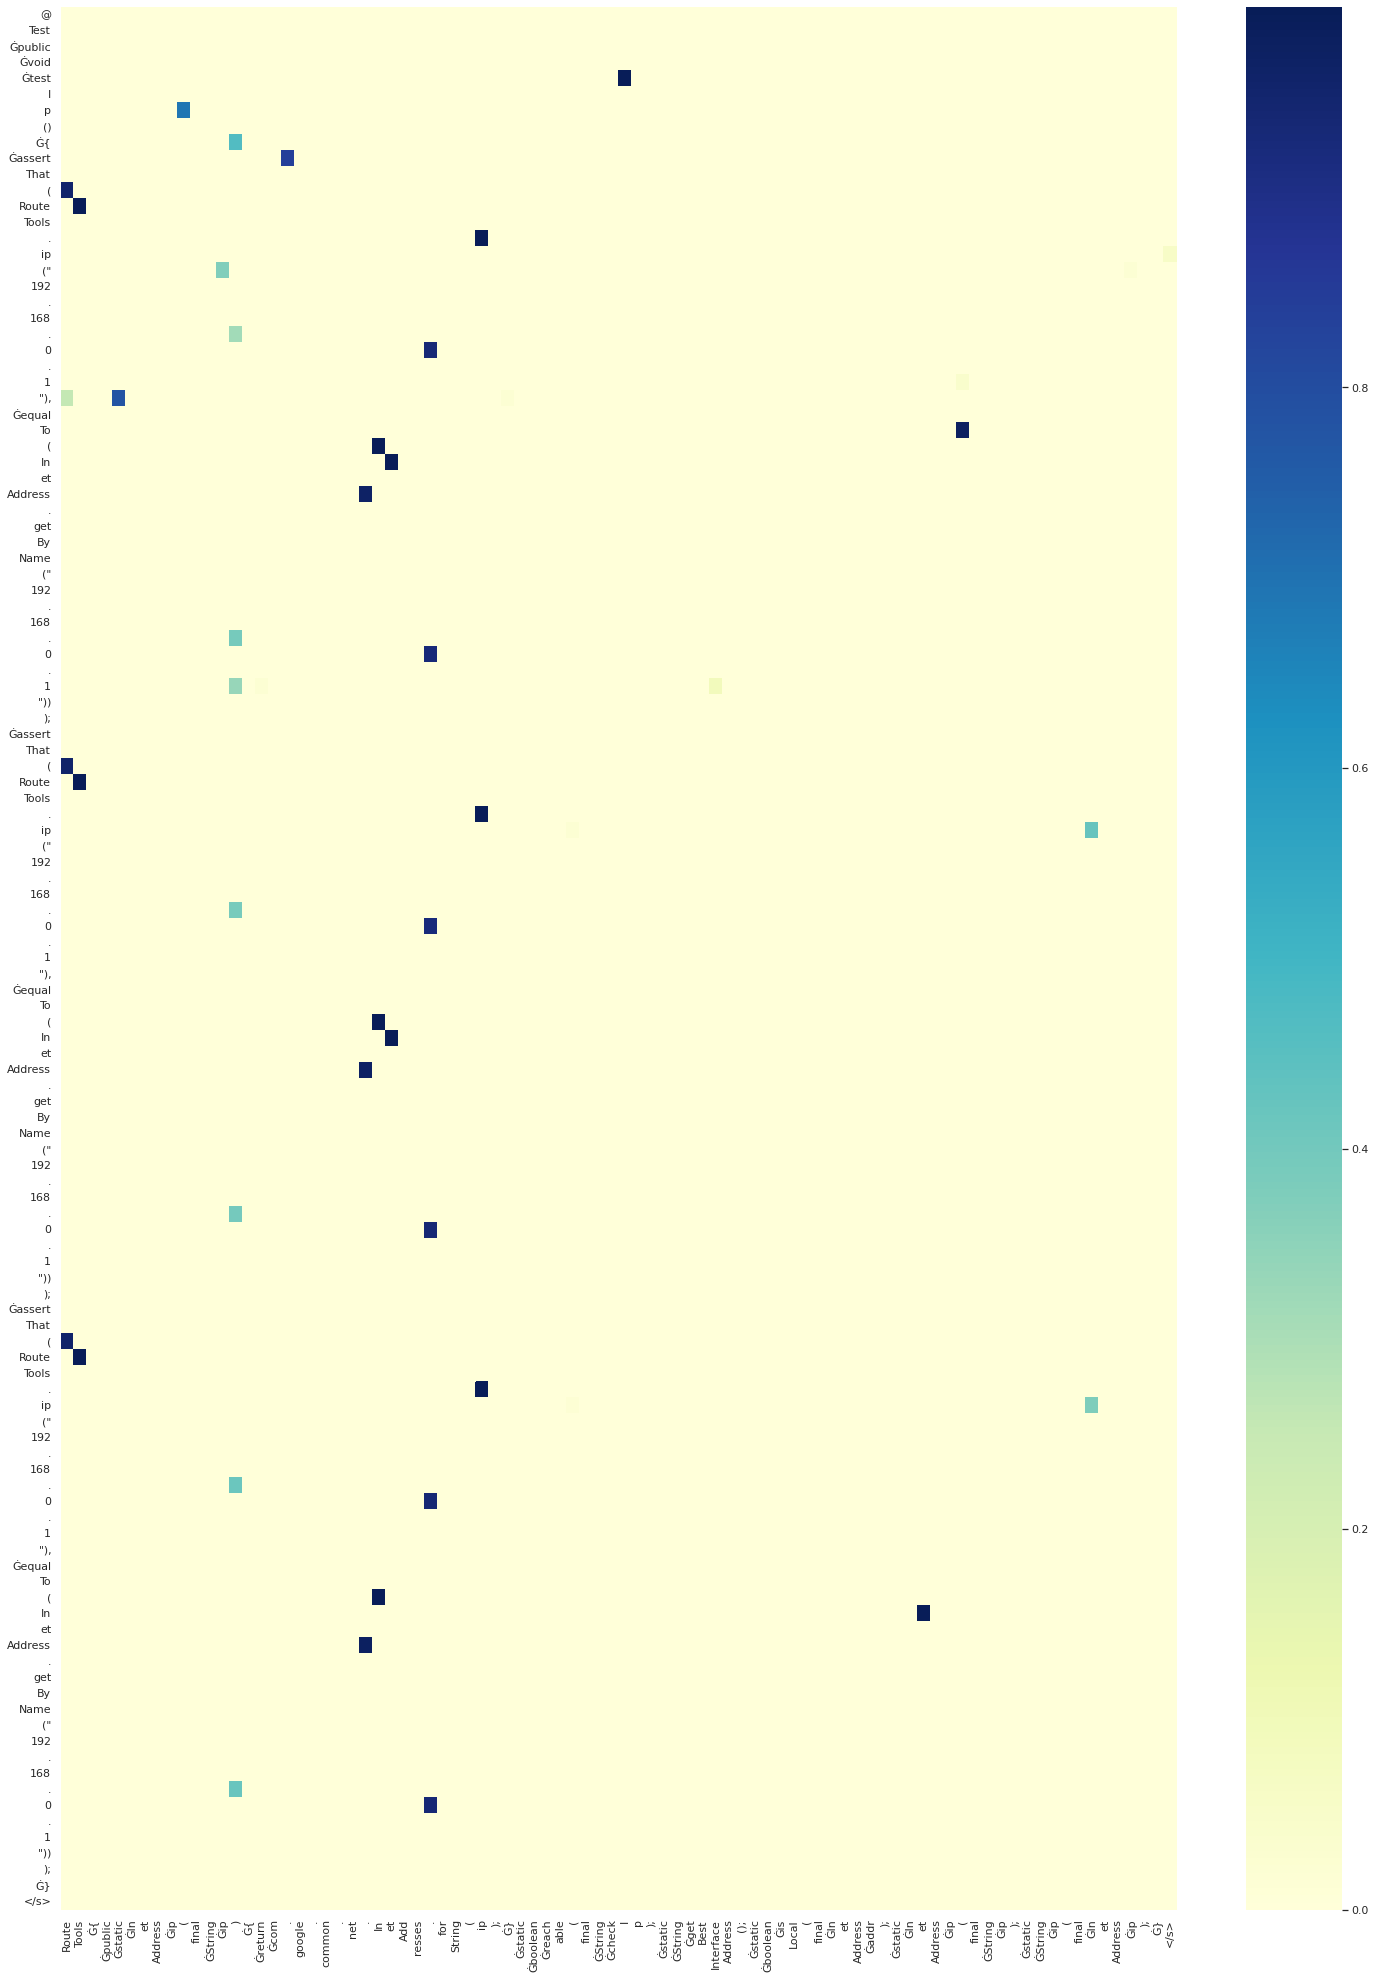

In [972]:
print_heatmap(np_rationales=np_src_rationales, fig_size = (25,35), font = 15)

### 2. Token-Level Granularity From Outputs to Outputs

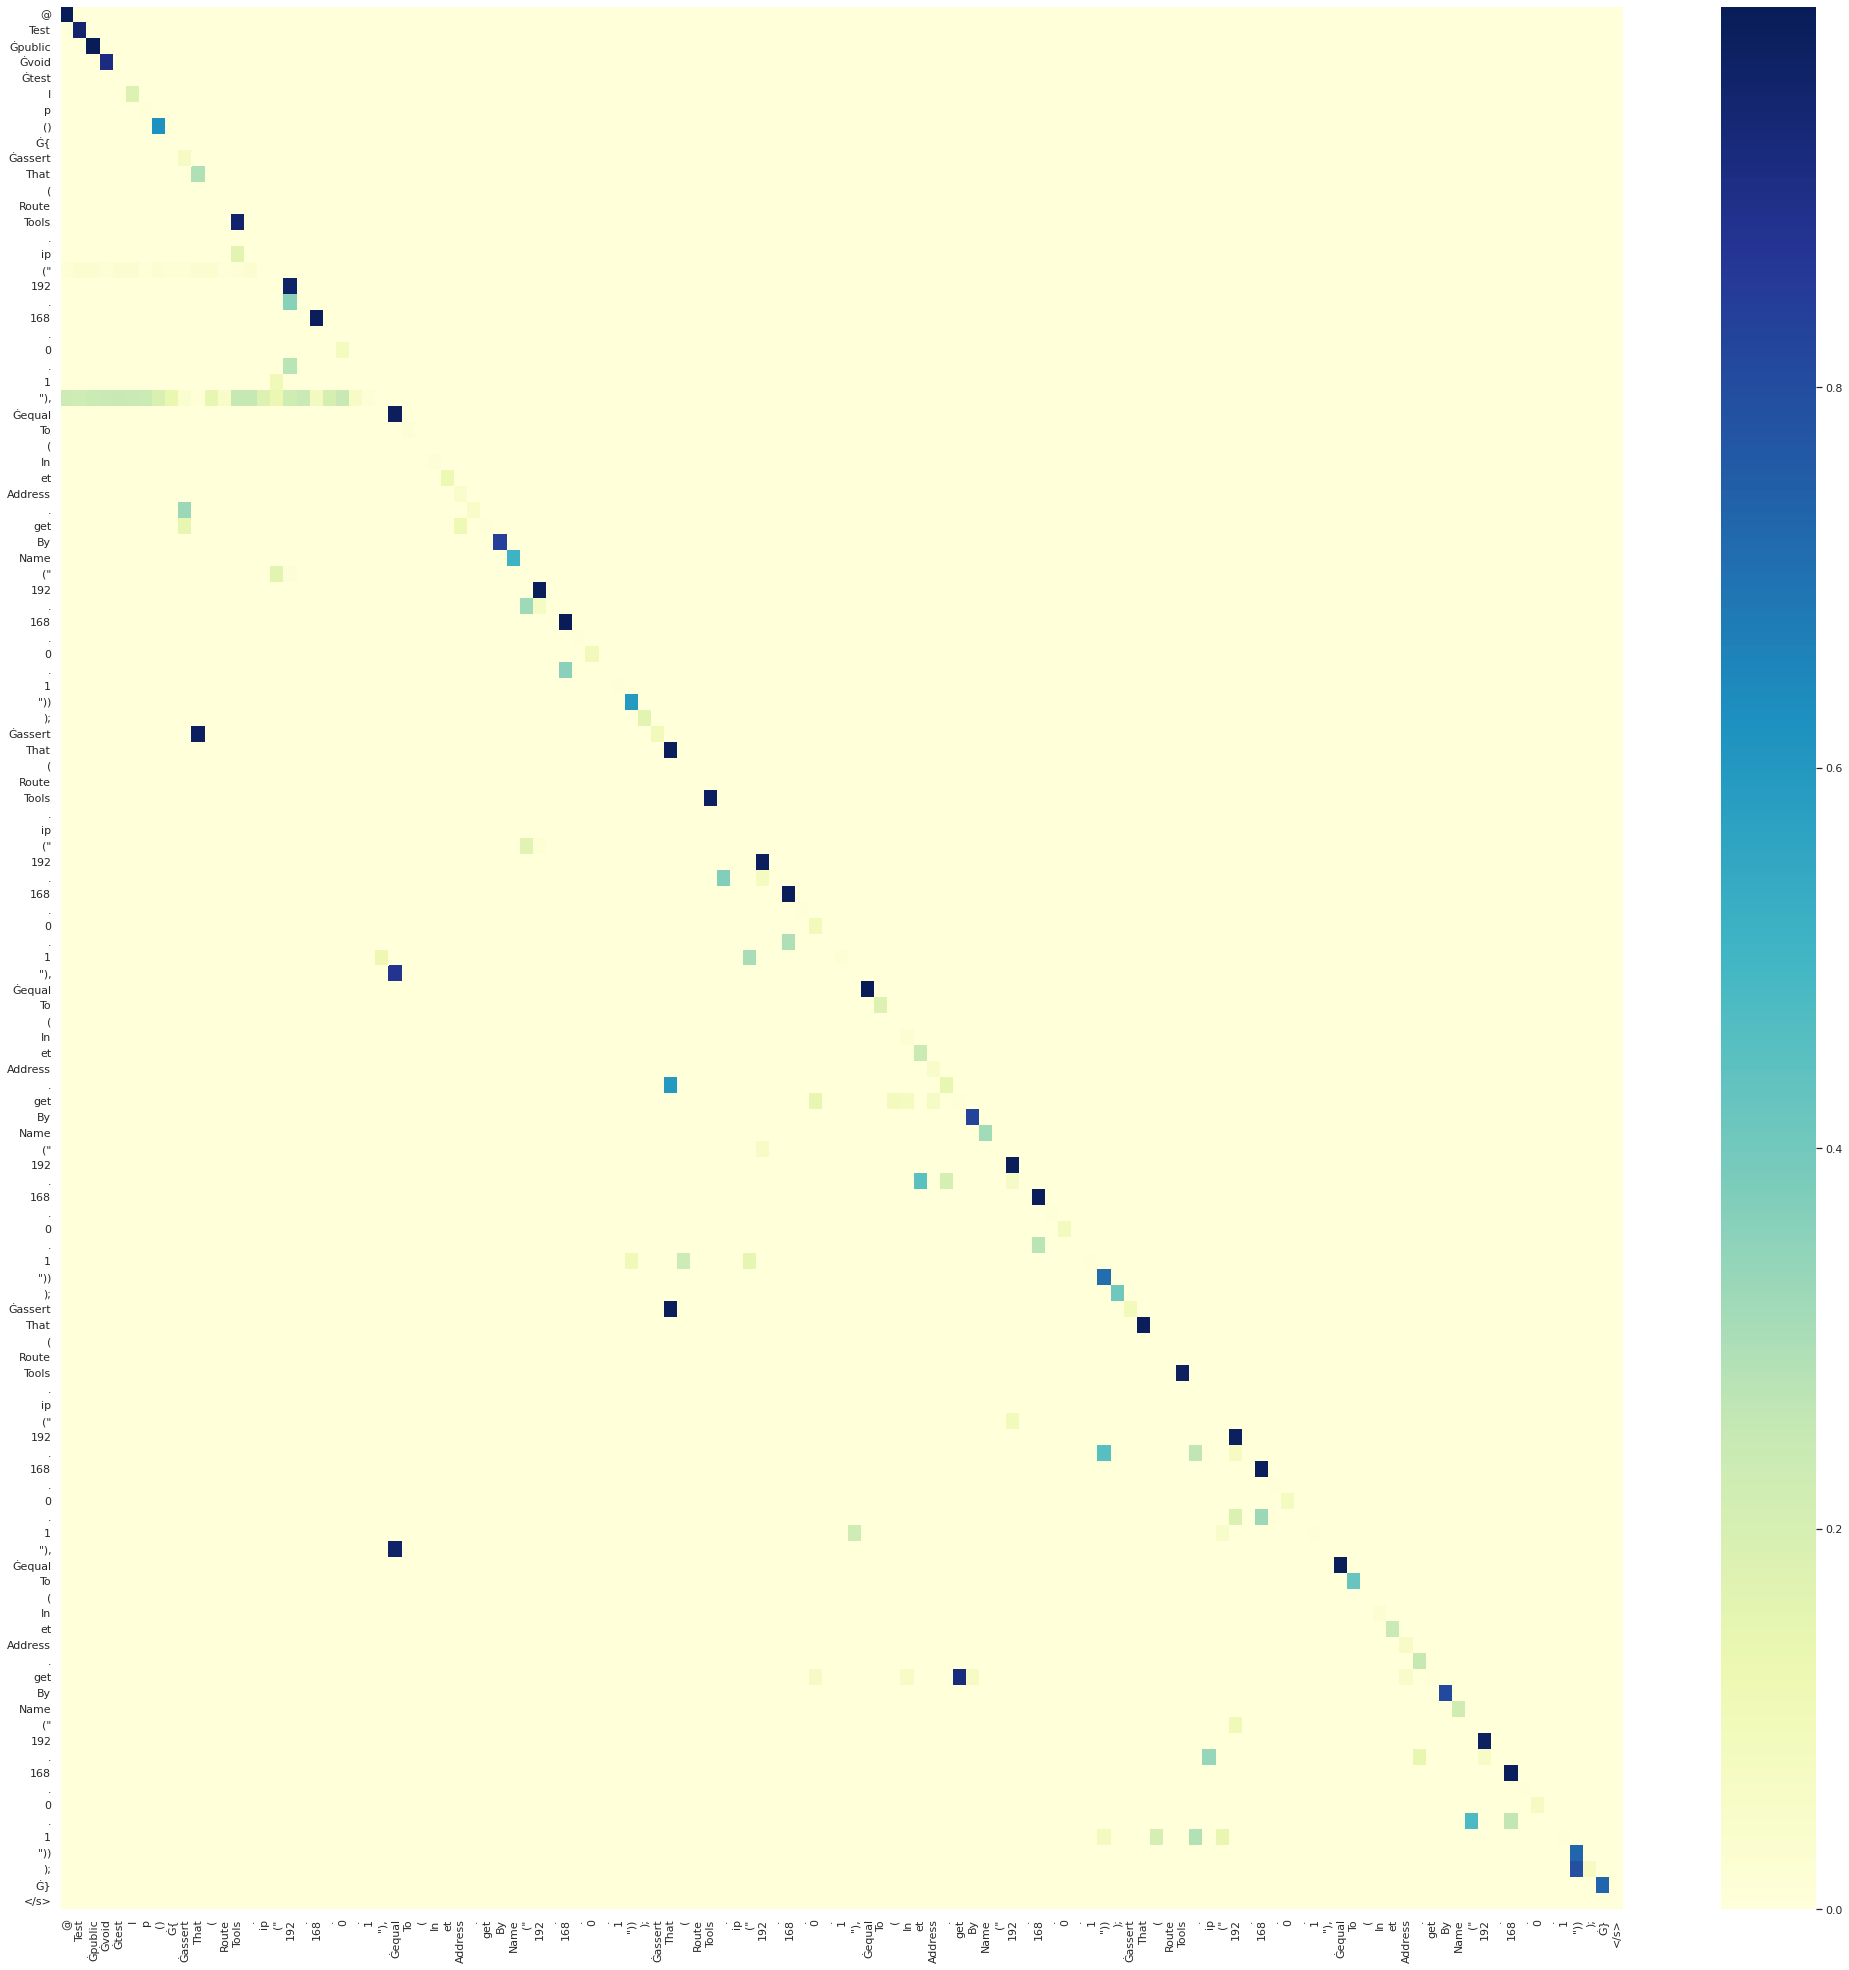

In [973]:
print_heatmap(
    np_rationales=np_tgt_rationales, 
    fig_size = (35,35), font = 15, 
    yticklabels=log['target_tokens_text'], 
    xticklabels=log['target_tokens_text'] )

In [974]:
for dict_token in code_rationales:
    rational = lambda list_log,typeset: [ (dict_tok['added_token_text'],round(dict_tok['true_token_prob'],6)) for dict_tok in list_log if dict_tok['from']==typeset]
    print_target = ' '.join( [str(tupl) for tupl  in rational(dict_token['log'],'target')] )
    print_source = ' '.join( [str(tupl) for tupl  in rational(dict_token['log'],'source')] )
    print(dict_token['goal_word'] + "\t<------" + "[ Target: "+ print_target +']' + "\t[ Source:" + print_source + "  ]")

Test	<------[ Target: ('@', 0.998047)]	[ Source:  ]
Ġpublic	<------[ Target: ('Test', 0.956334)]	[ Source:  ]
Ġvoid	<------[ Target: ('Ġpublic', 0.999979)]	[ Source:  ]
Ġtest	<------[ Target: ('Ġvoid', 0.914584)]	[ Source:  ]
I	<------[ Target: ('Ġtest', 0.001738)]	[ Source:('I', 0.999479)  ]
p	<------[ Target: ('I', 0.182195)]	[ Source:  ]
()	<------[ Target: ('p', 0.010375)]	[ Source:('(', 0.69137)  ]
Ġ{	<------[ Target: ('()', 0.624482)]	[ Source:  ]
Ġassert	<------[ Target: ('Ġ{', 0.003776)]	[ Source:(')', 0.46587)  ]
That	<------[ Target: ('Ġassert', 0.065141)]	[ Source:('.', 0.839916)  ]
(	<------[ Target: ('That', 0.291023)]	[ Source:  ]
Route	<------[ Target: ('(', 0.0)]	[ Source:('Route', 0.96034)  ]
Tools	<------[ Target: ('Route', 0.0)]	[ Source:('Tools', 0.999966)  ]
.	<------[ Target: ('Tools', 0.959117)]	[ Source:  ]
ip	<------[ Target: ('.', 3e-06)]	[ Source:('ip', 0.999983)  ]
("	<------[ Target: ('ip', 4.1e-05) ('Tools', 0.158694)]	[ Source:('</s>', 0.055657)  ]
192	<-

In [975]:
#export
def token_taxonomy() -> dict:
    return {
  "blocks": {
    "<{>": "{",
    "<}>": "}",
    "<[>": "[",
    "<]>": "]",
    "<(>": "(",
    "<)>": ")",
    "<;>": ";",
    "<return>": "return"
  },
  "exceptions": {
    "<catch>": "catch",
    "<try>": "try",
    "<finally>": "finally",
    "<throw>": "throw",
    "<throws>": "throws"
  },
  "oop": {
    "<class>": "class",
    "<instanceof>": "instanceof",
    "<interface>": "interface",
    "<private>": "private",
    "<protected>": "protected",
    "<public>": "public",
    "<abstract>": "abstract",
    "<extends>": "extends",
    "<package>": "package",
    "<this>": "this",
    "<implements>": "implements",
    "<import>": "import",
    "<new>": "new",
    "<super>": "super"
  },
  "tests": {
    "<assert>": "assert"
  },
  "declarations": {
    "<native>": "native",
    "<static>": "static",
    "<synchronized>": "synchronized",
    "<transient>": "transient",
    "<volatile>": "volatile",
    "<void>": "void",
    "<final>": "final",
    "<enum>": "enum"
  },
  "conditionals": {
    "<else>": "else",
    "<if>": "if",
    "<switch>": "switch",
    "<case>": "case",
    "<default>": "default"
  },
  "loops": {
    "<break>": "break",
    "<do>": "do",
    "<for>": "for",
    "<while>": "while",
    "<continue>": "continue"
  },
  "operators": {
    "<=>": "=",
    "<+>": "+",
    "<->": "-",
    "<*>": "*",
    "</>": "/",
    "<%>": "%",
    "<++>": "++",
    "<-->": "--",
    "<!>": "!",
    "<==>": "==",
    "<!=>": "!=",
    "<greater_equal>": ">=",
    "<lesser_equal>": "<=",
    "<&&>": "&&",
    "<||>": "||",
    "<?>": "?",
    "<:>": ":",
    "<~>": "~",
    "<double_lesser>": "<<",
    "<double_greater>": ">>",
    "<triple_greater>": ">>>",
    "<&>": "&",
    "<^>": "^",
    "<|>": "|"
  },
  "datatypes": {
    "<byte>": "byte",
    "<char>": "char",
    "<float>": "float",
    "<boolean>": "boolean",
    "<double>": "double",
    "<int>": "int",
    "<long>": "long",
    "<short>": "short",
    "<strictfp>": "strictfp"
  },
  "extra_tokens": {
    "<@>": "@",
    "<...>": "...",
    "<null>": "null",
    "<true>": "true",
    "<false>": "false",
    "<n>": "\n"
  }
}

In [976]:
tkn_taxonomy = token_taxonomy()

In [977]:
p_rationale.head(1)

,goal_token,typesets_tgt,typesets_src,rationale_pos_tgt,rationale_pos_src,rationale_prob_tgt,rationale_prob_src
0,Test,"[(@, 0.9980469942092896)]",[],[0],[],[0.9980469942092896],[]


In [978]:
#Map-Reduce Aggregation by Taxonomy
def map_rationale_by_tax(arr_typeset, tkn_taxonomy, non_stringent = True):
    list_category_prob = []
    list_category_token = []
    for typeset_row in arr_typeset: #Iterating rationales
        #print(typeset_row)
        dict_category_prob = {}
        dict_category_token = {}
        for category in tkn_taxonomy.keys(): #Iterating on Tax-Categories
            set_elems = set( tkn_taxonomy[category].values() )
            if non_stringent:
                set_elems = set_elems.union( set(['Ġ'+tok_elem for tok_elem in set_elems]) )
            dict_category_prob[category] = [ token_tuple[1] for token_tuple in typeset_row if token_tuple[0] in set_elems ]
            dict_category_token[category] = [ token_tuple for token_tuple in typeset_row if token_tuple[0] in set_elems ]
        list_category_prob.append(dict_category_prob) 
        list_category_token.append(dict_category_token)  
    return list_category_prob, list_category_token

In [979]:
list_category_prob_tgt, list_category_token_tgt = map_rationale_by_tax( arr_typeset=p_rationale.typesets_tgt.values, 
                                                tkn_taxonomy=tkn_taxonomy )
list_category_prob_src, list_category_token_src = map_rationale_by_tax( arr_typeset=p_rationale.typesets_src.values, 
                                                tkn_taxonomy=tkn_taxonomy )

In [980]:
p_rationale['category_prob_tgt'] = list_category_prob_tgt
p_rationale['category_token_tgt'] = list_category_token_tgt

p_rationale['category_prob_src'] = list_category_prob_src
p_rationale['category_token_src'] = list_category_token_src

In [981]:
p_rationale.head(1)

,goal_token,typesets_tgt,typesets_src,rationale_pos_tgt,rationale_pos_src,rationale_prob_tgt,rationale_prob_src,category_prob_tgt,category_token_tgt,category_prob_src,category_token_src
0,Test,"[(@, 0.9980469942092896)]",[],[0],[],[0.9980469942092896],[],"{'blocks': [], 'exceptions': [], 'oop': [], 't...","{'blocks': [], 'exceptions': [], 'oop': [], 't...","{'blocks': [], 'exceptions': [], 'oop': [], 't...","{'blocks': [], 'exceptions': [], 'oop': [], 't..."


In [982]:
#Filling and Aggregating Rationales
def taxonomy_aggregation(arr_category_prob, tkn_taxonomy, log, f_agg = np.median):

    #Independent Variable: Source Rows
    #Dependent Variable: Target Columns
    np_rationales = np.zeros(
                (  len( log['target_tokens_text'] ), 
                len( tkn_taxonomy.keys() ) ) 
                )

    for i, dict_tax in enumerate( arr_category_prob ):
        for j, category_tax in enumerate( dict_tax ):
            #print(category_tax,dict_tax[category_tax])
            if dict_tax[category_tax]:
                np_rationales[i][j] = f_agg( dict_tax[category_tax] ) #Agregation Function
    return np_rationales

In [983]:
np_rationales_src = taxonomy_aggregation(
    arr_category_prob = p_rationale.category_prob_src.values, 
    tkn_taxonomy = tkn_taxonomy, 
    log = log,
    f_agg = np.mean)

In [984]:
np_rationales_tgt = taxonomy_aggregation(
    arr_category_prob = p_rationale.category_prob_tgt.values, 
    tkn_taxonomy = tkn_taxonomy, 
    log = log,
    f_agg = np.mean)

### 3. Concept-Level Granularity at the source From Inputs to Outputs

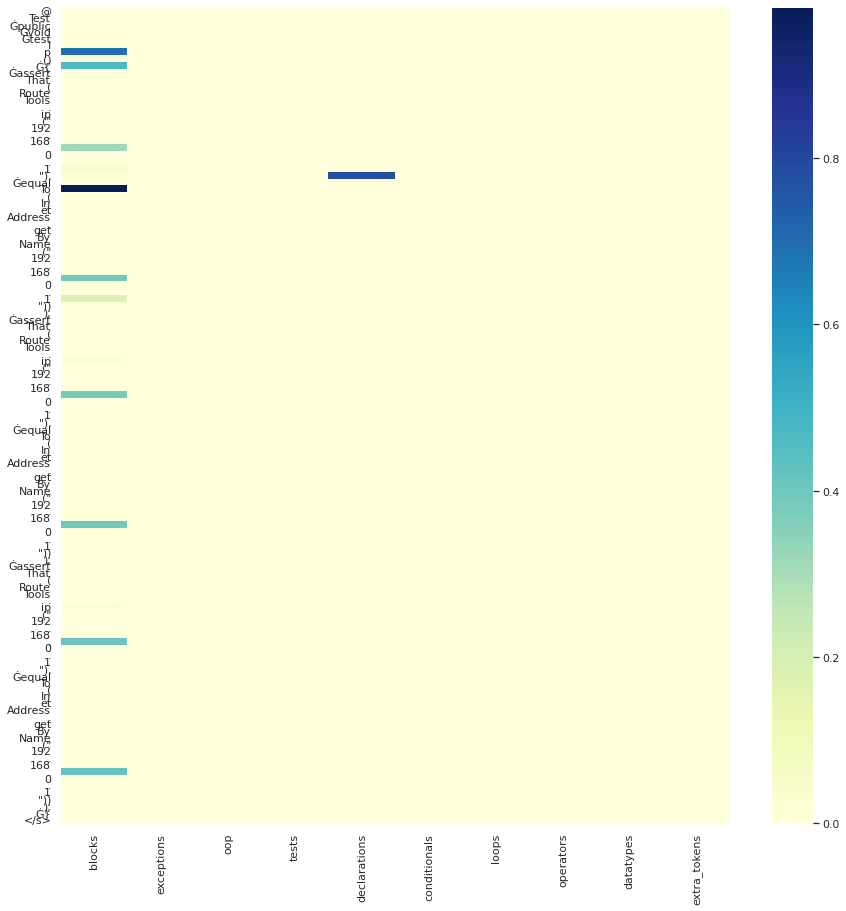

In [985]:
print_heatmap(
    np_rationales=np_rationales_src, 
    fig_size = (15,15), 
    font = 15, 
    yticklabels=log['target_tokens_text'], 
    xticklabels=tkn_taxonomy.keys())

### 3. Concept-Level Granularity at the source From Output to Output

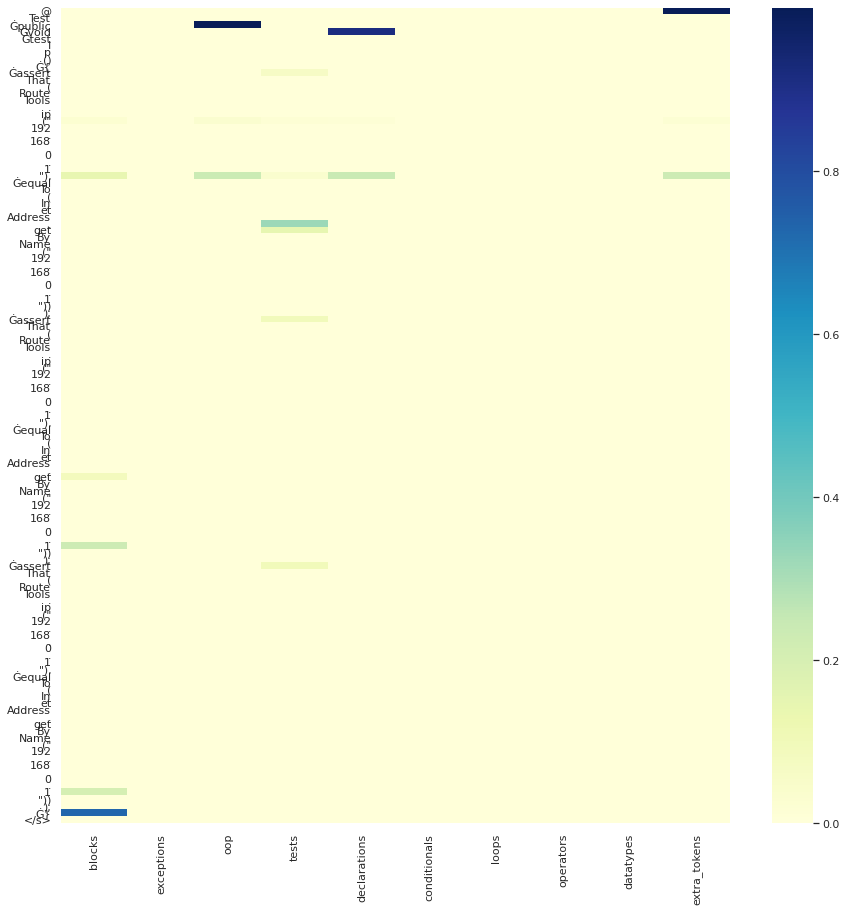

In [986]:
print_heatmap(
    np_rationales=np_rationales_tgt, 
    fig_size = (15,15), 
    font = 15, 
    yticklabels=log['target_tokens_text'], 
    xticklabels=tkn_taxonomy.keys())

### Rationales by General Taxonomy (as source and target)

In [987]:
dict_reduce_tax_prob_tgt = {k:[] for k in tkn_taxonomy.keys() } #dict.fromkeys( tkn_taxonomy.keys(), [] )
dict_reduce_tax_prob_src = {k:[] for k in tkn_taxonomy.keys() } #dict.fromkeys( tkn_taxonomy.keys(), [] )

In [988]:
non_stringent = True
for token_elem in set(p_rationale.goal_token.values):
    for category in tkn_taxonomy.keys(): #Iterating on Tax-Categories
        set_elems = set( tkn_taxonomy[category].values() )
        if non_stringent:
            set_elems = set_elems.union( set(['Ġ'+tok_elem for tok_elem in set_elems]) )
        if token_elem in set_elems:
            dict_reduce_tax_prob_tgt[category] = p_rationale[ p_rationale['goal_token'] == token_elem ].category_prob_tgt.values
            dict_reduce_tax_prob_src[category] = p_rationale[ p_rationale['goal_token'] == token_elem ].category_prob_src.values 

In [989]:
def merge_tax_dict(dict_a, dict_b):
    return {elem: dict_a[elem] + dict_b[elem]  for elem in dict_a}

In [990]:
def reduce_tax_dict( dict_reduce_tax_prob ):
    for tax in dict_reduce_tax_prob:
        if len(dict_reduce_tax_prob[tax]) > 0:
            dict_reduce_tax_prob[tax] = functools.reduce(lambda a, b: merge_tax_dict(a,b), dict_reduce_tax_prob[tax])
    pass

In [991]:
def reduce_tax_dict( dict_reduce_tax_prob ):
    return {lis: functools.reduce(lambda a, b: merge_tax_dict(a,b), dict_reduce_tax_prob[lis]) if len(dict_reduce_tax_prob[lis])>0 else {}  for lis in dict_reduce_tax_prob }

In [992]:
dict_reduce_tax_prob_tgt = reduce_tax_dict( dict_reduce_tax_prob= dict_reduce_tax_prob_tgt)
dict_reduce_tax_prob_src = reduce_tax_dict( dict_reduce_tax_prob= dict_reduce_tax_prob_src)

In [993]:
def reducing_rationales( 
    dict_reduce_tax_prob,  
    rows = len( tkn_taxonomy.keys() ), 
    columns = len( tkn_taxonomy.keys() ), 
    agg_f = np.mean ):
    #Independent Variable: Source Rows
    #Dependent Variable: Target Columns
    np_rationales = np.zeros( ( rows, columns ) )
    for i, row_tax in enumerate( dict_reduce_tax_prob ):
        dict_inner = dict_reduce_tax_prob[row_tax]
        #print(i)
        if dict_inner:
            #print(i)
            for j, column_tax in enumerate( dict_inner ):
                #print(j)
                list_tax = dict_inner[column_tax]
                if list_tax:
                    np_rationales[i][j] = agg_f( list_tax ) #Agregation Function
    return np_rationales

### 4. Concept-Level Granularity (src and tgt) From Output to Output

In [994]:
np_rationales_avg = reducing_rationales(dict_reduce_tax_prob = dict_reduce_tax_prob_tgt, agg_f = np.mean)
np_rationales_min = reducing_rationales(dict_reduce_tax_prob = dict_reduce_tax_prob_tgt, agg_f = np.min)

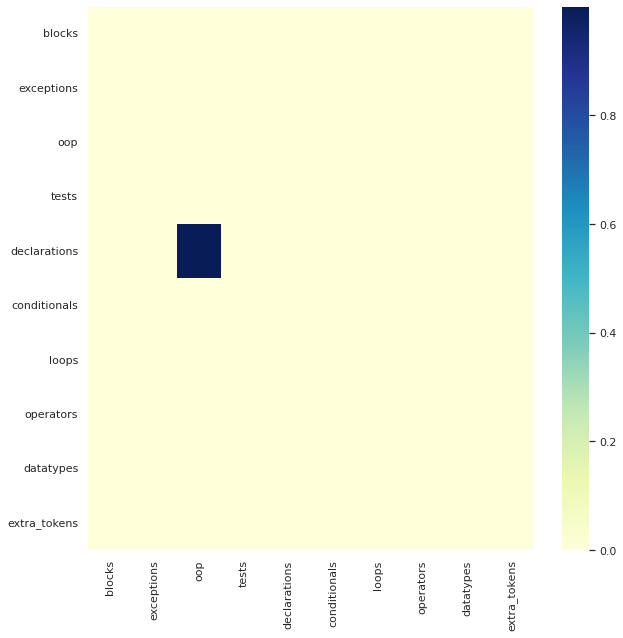

In [995]:
print_heatmap(
    np_rationales=np_rationales_avg, 
    fig_size = (10,10), 
    font = 15,
    yticklabels=tkn_taxonomy.keys() , 
    xticklabels=tkn_taxonomy.keys() )

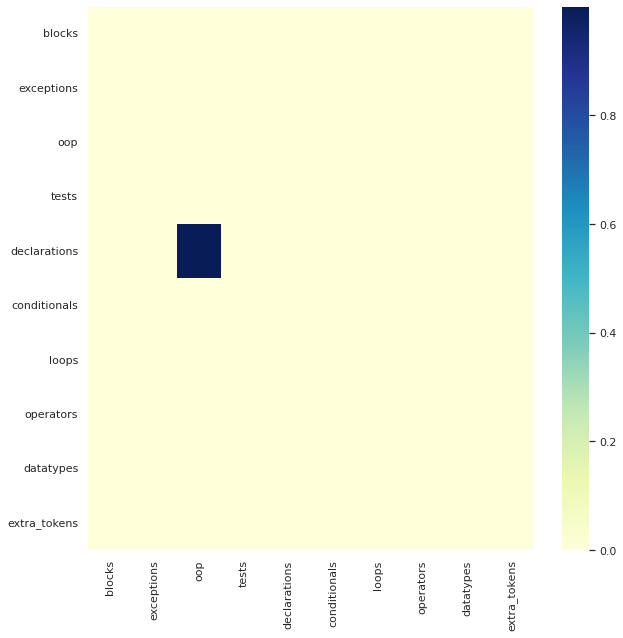

In [996]:
print_heatmap(
    np_rationales=np_rationales_min, 
    fig_size = (10,10), 
    font = 15,
    yticklabels=tkn_taxonomy.keys() , 
    xticklabels=tkn_taxonomy.keys() )

### 5. Concept-Level Granularity (src and tgt) From Input to Output

In [997]:
np_rationales_avg = reducing_rationales(dict_reduce_tax_prob = dict_reduce_tax_prob_src, agg_f = np.mean)
np_rationales_min = reducing_rationales(dict_reduce_tax_prob = dict_reduce_tax_prob_src, agg_f = np.min)

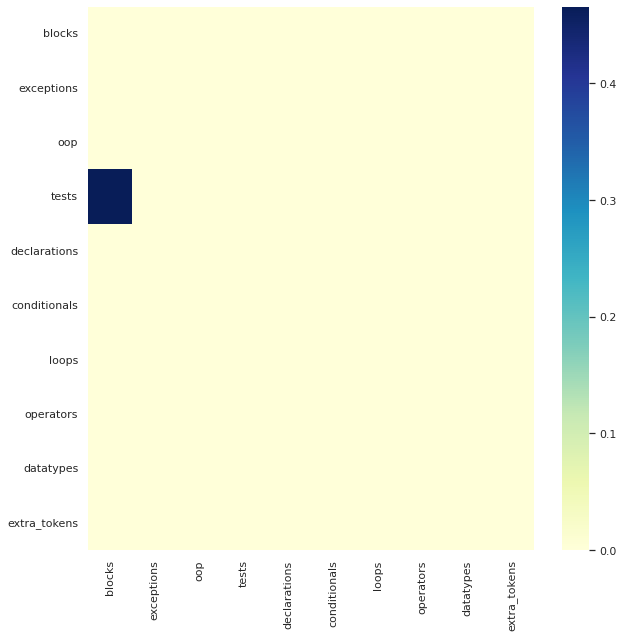

In [998]:
print_heatmap(
    np_rationales=np_rationales_avg, 
    fig_size = (10,10), 
    font = 15,
    yticklabels=tkn_taxonomy.keys() , 
    xticklabels=tkn_taxonomy.keys() )

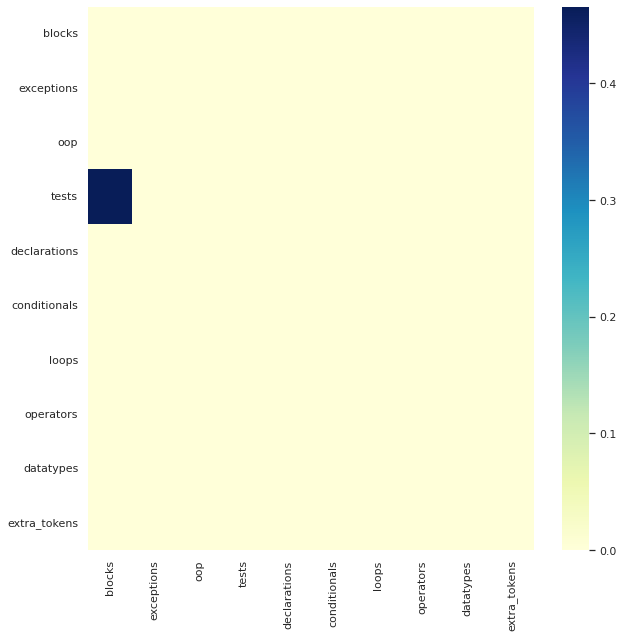

In [999]:
print_heatmap(
    np_rationales=np_rationales_min, 
    fig_size = (10,10), 
    font = 15,
    yticklabels=tkn_taxonomy.keys() , 
    xticklabels=tkn_taxonomy.keys() )